### [Section de Prototypage] Comparons les convergences de `KrylovKit` et `Arpack` pour trouver les valeurs propres des deux opérateurs 2D rescalé et non rescalé

In [ ]:
using Arpack
# 𝔥m = Matrix(𝔥);
@time E_arpack, ϕ_arpack = Arpack.eigs(Ĥ_res, nev=1, ncv=40, which=:SR, tol=1e-16, maxiter=1000, sigma=nothing, ritzvec=true, v0=zeros((0,)));

In [ ]:
@time lE_krylovkit, lϕ_krylovkit, info = KrylovKit.eigsolve(Ĥ_res, N*N, 2, :SR, krylovdim=40);

In [ ]:
ϕ_arpack = reshape(ϕ_arpack,N*N);
E_arpack = E_arpack[1];
println("norme Arpack")
@show norm(𝔥*ϕ_arpack - E_arpack*ϕ_arpack);

E_kryllovkit = lE_krylovkit[1];
ϕ_krylovkit  = lϕ_krylovkit[1];
println("norme KrylovKit")
@show norm(𝔥*ϕ_krylovkit - E_kryllovkit*ϕ_krylovkit);

## Théorie des perturbations, GPU

In [ ]:
using IterativeSolvers
using LinearAlgebra
using CUDA
CUDA.reclaim()

Ψ₀ = cu(convert(Vector{Float32}, ΨHBO));
W = cu(convert(Matrix{Float32}, Ŵ));
H₀ = cu(convert(SparseMatrixCSC{Float32}, Ĥ⁰));



Π_par  = Ψ₀*Ψ₀';
Π_ort  = Diagonal(CUDA.ones(N*N)) - Π_par;
Qmax   = 5;

P_ort  = H₀*Π_ort; # produit sparse*dense fonctionne mais pas dans l'autre sens
P_ort  = Π_ort*P_ort - EHBO*Π_ort; # Π⟂(H₀-E₀)Π⟂
P_par  = H₀*Π_par;
P_par  = Π_par*P_par - EHBO*Π_par; # Π∥(H₀-E₀)Π∥

llΨ    = zeros(Float32, N*N, Qmax);
llE    = zeros(Float32, Qmax);

R_ort  = -Π_ort*W; 
b      = R_ort*Ψ₀;
b_acc  = zeros(Float32, N*N);
Ψ_acc1 = CUDA.zeros(N*N);
Ψ_acc2 = CUDA.zeros(N*N);

# GC ordre 1 et sauvegarde
Ψ_acc1[:] = cg(P_ort, b);
Ψ_acc2[:] = Ψ_acc1;
llΨ[:,1]  = Array(Ψ_acc1);
llE[1]    = Ψ₀'*W*Ψ₀;

R_par = -P_par*W + llE[1]*P_par;
R_ort +=           llE[1]*P_ort;



for q ∈ 2:Qmax
    for i ∈ 1:(q-1)
        llE[q] = llE[q] -1/2*dot(llΨ[i], llΨ[q-i]);
    end
    
    fill!(b_acc, 0);
    fill!(b,     0);
    for i ∈ 1:(q-2)
        b_acc[:] = @views b_acc + llE[q-i]*llΨ[:,i];
    end
    b[:] = cu(b_acc);
    b[:] = b + llE[q]*Ψ₀;
    Ψ_acc1[:] = cg(P_ort, Π_ort*b + R_ort*Ψ_acc1);
    Ψ_acc2[:] = cg(P_ort, Π_par*b + R_par*Ψ_acc2) + Ψ_acc1;
    llΨ[:,q] = Array(Ψ_acc2);
end

Ψ_sol = copy(ΨHBO);
for i in 1:Qmax
    Ψ_sol[:] = @views Ψ_sol + λ^i*llΨ[:,i]
end

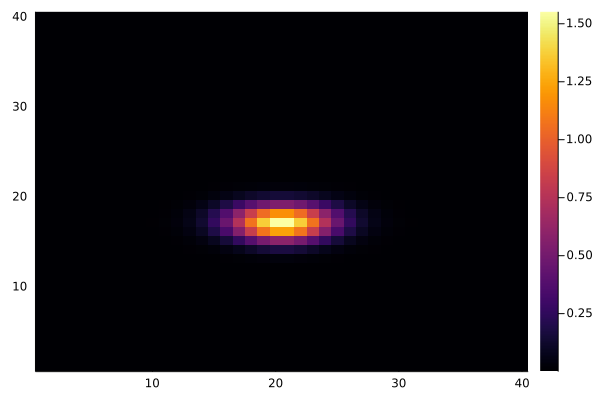

In [53]:
heatmap(densité*reshape(convert(Vector{Float64},Ψ_sol.^2),N,N)')

In [91]:
r = sprand(4,4,.2)
s = cu(convert(Matrix{Float32}, r))

4×4 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0       0.0       0.0
 0.0  0.0       0.0       0.0
 0.0  0.190787  0.0       0.0
 0.0  0.67993   0.985651  0.0

In [149]:
N_t = 1000
r = convert(Float32, 5.4)
s = CUDA.rand(N_t,N_t);
t = CUDA.CUSPARSE.CuSparseMatrixCSC(sprand(Float32,N_t,N_t,1/N_t))
CUDA.@time t*s; # s*t non
CUDA.@time s*s;

  0.008730 seconds (101 CPU allocations: 4.344 KiB) (1 GPU allocation: 3.815 MiB, 0.21% memmgmt time)
  0.010358 seconds (83 CPU allocations: 4.031 KiB) (1 GPU allocation: 3.815 MiB, 0.16% memmgmt time)


In [143]:
N_t = 3000;
v1 = rand(N_t)
v2 = rand(N_t)
@time v1'*v2
@time dot(v1,v2)

  0.004698 seconds (1.88 k allocations: 119.268 KiB, 92.78% compilation time)
  0.004208 seconds (16 allocations: 928 bytes, 99.57% compilation time)


749.4585632102888

In [43]:
using CUDA
a = CUDA.ones(5)
r = CUDA.rand(5,5)
t = zeros(5,5)
#r - Diagonal(a)
CUDA.@time t[:,1] = Array(r*a);

  0.001355 seconds (59 CPU allocations: 3.688 KiB) (1 GPU allocation: 20 bytes, 1.18% memmgmt time)


In [39]:
using CUDA
N = 5000
t = CUDA.rand(N);
CUDA.@time @views t[:] = CUDA.ones(N);

  0.001379 seconds (92 CPU allocations: 4.922 KiB) (1 GPU allocation: 19.531 KiB, 1.21% memmgmt time)


In [40]:
CUDA.@time t[:] = CUDA.ones(N);
t = nothing
CUDA.reclaim()

  0.001102 seconds (91 CPU allocations: 4.891 KiB) (1 GPU allocation: 19.531 KiB, 1.66% memmgmt time)


In [68]:
a = CUDA.rand(5,5)
b[:] = a
fill!(a,0)
b

5×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.129655   0.195801  0.961048   0.391877   0.879249
 0.0633536  0.198139  0.0132472  0.379528   0.1819
 0.173148   0.963232  0.493694   0.0165312  0.0623482
 0.53322    0.706055  0.596665   0.29366    0.830973
 0.862015   0.154294  0.284755   0.926223   0.597311

In [59]:
a = CUDA.ones(5)
r = CUDA.rand(5,5)
t = CUDA.rand(5)
s = CUDA.rand(5,5)
CUDA.@time d = a + s*t;
CUDA.@time cg(r,d)

  0.001198 seconds (86 CPU allocations: 5.328 KiB) (2 GPU allocations: 40 bytes, 1.44% memmgmt time)
  0.003298 seconds (731 CPU allocations: 46.703 KiB) (4 GPU allocations: 80 bytes, 0.57% memmgmt time)


5-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  1.7119342
  1.191223
  1.4654402
  5.1460648
 -0.35538095

In [63]:
CUDA.@time cg(r,a+s*t)

  0.003012 seconds (767 CPU allocations: 48.656 KiB) (6 GPU allocations: 120 bytes, 0.85% memmgmt time)


5-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  1.7119342
  1.191223
  1.4654402
  5.1460648
 -0.35538095

In [46]:
CUDA.@time fill!(r, 0)

  0.001406 seconds (53 CPU allocations: 3.438 KiB)


5×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [75]:
typeof(t)

CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}

In [32]:
HmEHBO = Ĥ⁰-Diagonal(EHBO*ones(N*N))
@show typeof(HmEHBO);
@show ishermitian(HmEHBO);
@show isposdef(HmEHBO)
@time F = factorize(HmEHBO);
vals, ~, infos = KrylovKit.eigsolve(HmEHBO, N*N, 1, :SR, krylovdim=20); # vérification si la plus petite valeur propre est bien nulle
@assert infos.converged >= 1
@show vals[1];
@show norm(Ĥ⁰*ΨHBO-EHBO*ΨHBO); # valeur propre (0) est bien majorée par la norme du résidu

typeof(HmEHBO) = SparseMatrixCSC{Float64, Int64}
ishermitian(HmEHBO) = true
isposdef(HmEHBO) = false
  0.001689 seconds (65 allocations: 1.353 MiB)
vals[1] = -2.062433948425952e-14
norm(Ĥ⁰ * ΨHBO - EHBO * ΨHBO) = 3.8457038344180585e-14


In [19]:
using CUDA
CUDA.reclaim()
Π = convert(Matrix{Float32}, ΨHBO*ΨHBO');
Π_gpu = cu(Π); # 6400×6400 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
HmEHBO = convert(SparseMatrixCSC{Float32}, Ĥ⁰-Diagonal(EHBO*ones(N*N))); 
HmEHBO_gpu = cu(HmEHBO); # 6400×6400 CUDA.CUSPARSE.CuSparseMatrixCSC{Float32, Int32} with 31680 stored entries:
CUDA.@time HmEHBO_gpu = HmEHBO_gpu*Π_gpu;
CUDA.@time HmEHBO_gpu = Π_gpu*HmEHBO_gpu;

In [ ]:
# construction des vecteurs sur GPU ensuite pour les calculs
using CUDA;
CUDA.device_reset!()
CUDA.reclaim()

# Π projecteur sur l'orthogonal de ΨHBO
Π = Matrix(I,N*N,N*N) - ΨHBO*ΨHBO';
Π_32       = convert(Matrix{Float32}, Π); # changer en double précision 64 bits des GPU équipés de cœors adaptés (cluster)
Π_gpu      = cu(Π_32);

# H - E0
HmEHBO = Ĥ⁰-Diagonal(EHBO*ones(N*N))
HmEHBO_32  = convert(SparseMatrixCSC{Float32}, HmEHBO); # idem
HmEHBO_gpu = cu(HmEHBO_32);

# Ŵ Perturbation
# ... W existe déjà
W_32 = convert(Matrix{Float32}, Ŵ);
W_gpu = cu(W_32);

# membre de droite
bcg = -Π*Ŵ*ΨHBO # toujours faire les produits en 64 bits avant de convertir en 32bits pour éviter la propagation d'erreurs
bcg_32 = convert(Array{Float32}, bcg);
bcg_gpu = cu(bcg_32);

# application linéaire sur laquelle résoudre
Acg = Π*HmEHBO*Π;
Acg_32 = convert(Matrix{Float32}, Acg);
Acg_gpu = cu(Acg_32);


# types 
@show typeof(Π_gpu);
@show typeof(HmEHBO_gpu);
@show typeof(W_gpu);
@show typeof(bcg_gpu);


In [51]:
N = 50*50;
A = rand(N,N);
t = rand(N);
s = rand(N);
# @time t'*A*s
@time dot(t, A, s);
using CUDA
A_gpu = cu(A);
t_gpu = cu(t);
s_gpu = cu(s);
CUDA.@time t_gpu'*A_gpu*s_gpu;

  0.004256 seconds (1 allocation: 16 bytes)
  0.003907 seconds (32 CPU allocations: 640 bytes) (1 GPU allocation: 9.766 KiB, 0.35% memmgmt time)


In [28]:
# gradients conjugués avec et sans gpu
using IterativeSolvers;

# ordre 1
CUDA.@time Ψ1_gpu = cg(Acg_gpu, bcg_gpu);
@time      Ψ1_32  = cg(Acg_32, bcg_32);
# @assert Ψ1_32 ≈ Vector(Ψ1_gpu);
E1 = (ΨHBO+λ*Ψ1_32)'*(Ĥ⁰+λ*Ŵ)*(ΨHBO+λ*Ψ1_32);

# ordre 2 (gpu uniquement)
# màj membre de droite
bcg_gpu = -Acg_gpu*Ψ1_gpu + E1*Ψ1_gpu # toujours faire les produits avant de convertir en 32bits au possible
CUDA.@time Ψ2_gpu = cg(Acg_gpu, bcg_gpu);

 29.374644 seconds (63.66 M CPU allocations: 3.321 GiB, 4.04% gc time) (4 GPU allocations: 39.062 KiB, 0.00% memmgmt time)
  0.456681 seconds (1.24 M allocations: 65.344 MiB, 85.83% compilation time)
 12.264701 seconds (35.44 M CPU allocations: 1.835 GiB, 4.80% gc time) (4 GPU allocations: 78.125 KiB, 0.00% memmgmt time)
